# Load and view data

The most time-consuming and frustrating part of using Deep Learning for image analysis is data handling. The goal of this task is to get some of the data access and cleaning issues out of the way - then during the in-person course we will be able to run fun experiments and try different methods rather than spend time uploading and renaming files.

The result of doing this task should be a small tutorial for how to use your data. Ideally, an external person should be able to run this notebook and get an idea how your data is organized, how to open and view it, and what the goal of your analysis is.

We will use the [nuclei segmentation data](https://www.kaggle.com/c/data-science-bowl-2018/data) as an example. It's a dataset for a pretty standard segmentation task. If your task is not segmentation, some of the parts might not make sense. Instead of trying to stay as close as possible to the example, think what makes most sense for your own data. If you are not sure what to do, don't hesitate to contact your group's TAs.


## Downloading the data - BARD

Data used in webinars is already downloaded and can be found in `/scratch/k8s/denbi/ADL4IA_pre-course/`

In [1]:
data_dir = "/scratch/denbi/k8s/ADL4IA_pre-course/kaggle_data/"

In [2]:
!ls -ltrh {data_dir}

total 80M
drwxr-xr-x. 272 25473 738 270 Jan 13 14:49 nuclei_val_data
drwxr-xr-x. 402 25473 738 400 Jan 13 14:50 nuclei_train_data
-rw-r--r--.   1 25473 738 80M Jan 13 14:50 stage1_train.zip


## The libraries

In [3]:
from pathlib import Path
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray, rgba2rgb
import napari

## Clean up data and upload to BARD

Organize the data you want to use for the course and upload it to BARD. Refer to the upload instructions in the e-Campus.

## Data description

### Task

Write a short description of your data. Include the following information:

- Context: where data comes from and what is the image analysis task	
- Folder structure, file naming scheme, image channels
- File format(s)
- What metadata is important for the task and how to find it? Metadata can include pixel size, ground truth labels, sample names or experiments and be found in file names, image file metadata or in a separate annotation table

### Example
Look at the [description on the page of the competition](https://www.kaggle.com/c/data-science-bowl-2018/data), especially the File description section.

## Load data as `numpy` array

`numpy` arrays are a basic way to represent multidimensional arrays. If you know how to open an image as a `numpy` array, most likely it will be possible to use the data for pretty much any kind of analysis in Python.

- If your images are in `tiff` format, you can use `imageio`
- If your images are in some format specific for the microscope, for example, `nd2`, `lif`, `vsi`, you might be able to open it using [`python-bioformats`](https://pythonhosted.org/python-bioformats/) to load them
- If your images are large, consider converting them to [`zarr`](https://zarr.readthedocs.io/en/stable/) format to be able to quickly load part of the image without loading the whole image into memory 

### Task
- Choose one or two samples and load all corresponding images into a `numpy` array
- Plot the image
- Check image size, data type and value distribution. Are they as you expect?
- If the images are very large, try to convert your data to `zarr` and read only parts of the data at a time

### Example

In [4]:
def load_sample(data_dir, sample_name):
    data_dir = Path(data_dir)
    image_path = data_dir / sample_name / 'images' / f"{sample_name}.png"
    
    image = imageio.imread(image_path)
    if image.shape[-1] == 4:
        image = rgba2rgb(image)
    if image.shape[-1] == 3:
        image = rgb2gray(image)
    masks_dir = data_dir / sample_name / 'masks'
    # masks directory has multiple images - one mask per nucleus
    masks_list = list(masks_dir.glob("*png"))
    # create an empty array
    mask = np.zeros_like(image)
    # iterate through the images to sum them up to one mask
    for idx, mask_name in enumerate(masks_list):
        one_nucleus_mask = imageio.imread(mask_name)
        # add this nucleus to the mask
        mask += one_nucleus_mask * (idx + 1)
    return image, mask


def plot_sample(image, mask):
    plt.figure()
    plt.imshow(image, cmap="Greys_r")
    plt.imshow(mask, cmap="prism", alpha=0.2 * (mask>0).astype(np.float32))
    
    plt.figure()
    plt.hist(image.flatten(), bins=50)
    plt.title("Intensity distribution of raw image")
    plt.show()
    
    print("Image shape", image.shape)
    print("Image dtype", image.dtype)
    print("Mask dtype", mask.dtype)

In [5]:
data_dir = Path(data_dir)

Raw image

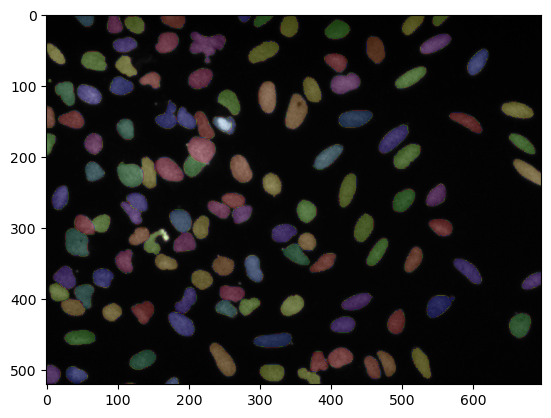

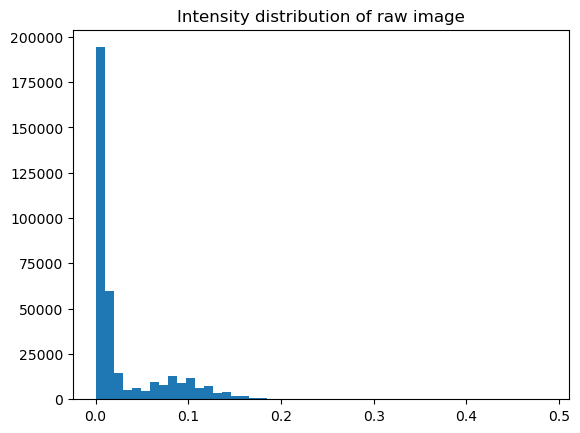

Image shape (520, 696)
Image dtype float64
Mask dtype float64


In [6]:
sample_name = "98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0"
image, mask = load_sample(data_dir / "nuclei_train_data", sample_name)
plot_sample(image, mask)

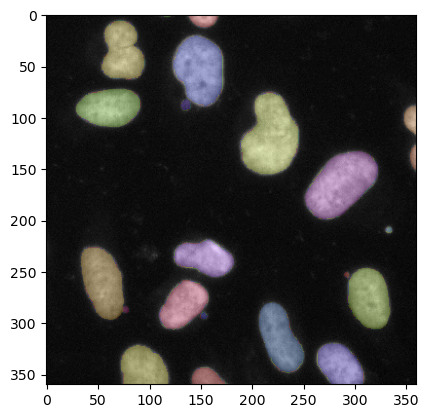

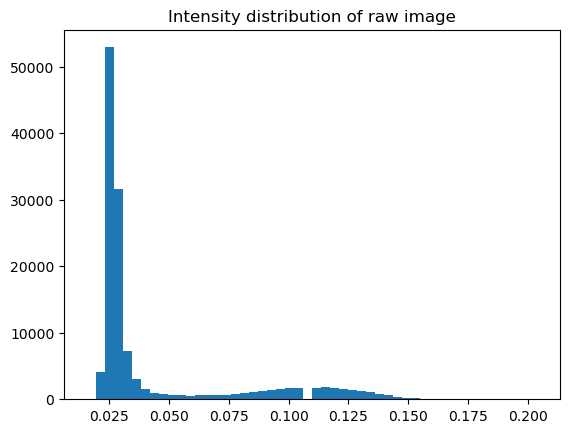

Image shape (360, 360)
Image dtype float64
Mask dtype float64


In [7]:
sample_name = "2a2032c4ed78f3fc64de7e5efd0bec26a81680b07404eaa54a1744b7ab3f8365"
image, mask = load_sample(data_dir / "nuclei_train_data", sample_name)
plot_sample(image, mask)

### Task

Training a deep learning model is based on random sampling of the dataset. Implement a function that outputs a random sample/ground truth  pair out of your dataset.

### Example

In [8]:
def get_random_sample(dataset_dir):
    dataset_dir = Path(dataset_dir)
    sample_list = [sample_dir.name for sample_dir in dataset_dir.glob("*")]
    idx = np.random.randint(0, len(sample_list))
    image, mask = load_sample(dataset_dir, sample_list[idx])
    return image, mask, sample_list[idx]

831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6


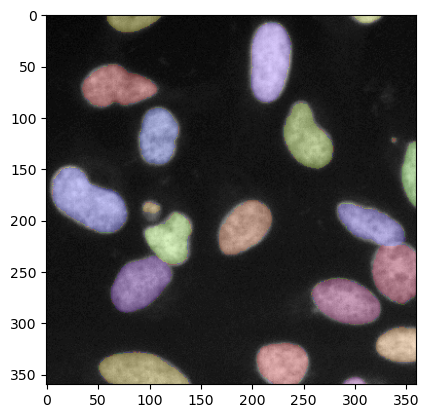

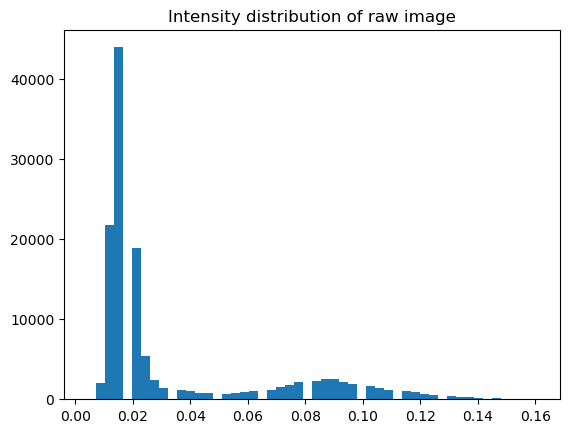

Image shape (360, 360)
Image dtype float64
Mask dtype float64


In [9]:
image, mask, sample_name = get_random_sample(data_dir / "nuclei_train_data")
print(sample_name)
plot_sample(image, mask)

## View data in `napari`

[`napari`](https://napari.org/stable/) is a data viewer designed for multi-dimensional biological images. We recommend to use it because it's easy to interact with `napari` from `python`. Look at the [general intro to napari](https://napari.org/stable/tutorials/fundamentals/viewer.html).

### Task

Start `napari` from the notebook and create layers for some example images

### Example

In [10]:
v = napari.Viewer()

In [11]:
image, mask, sample_name =  get_random_sample(data_dir / "nuclei_train_data")
v.add_image(image, name="raw")
v.add_labels(mask.astype(np.uint16), name="mask")

<Labels layer 'mask' at 0x7f44e403dbb0>

After running previous two cells you should see a separate window looking something like this:

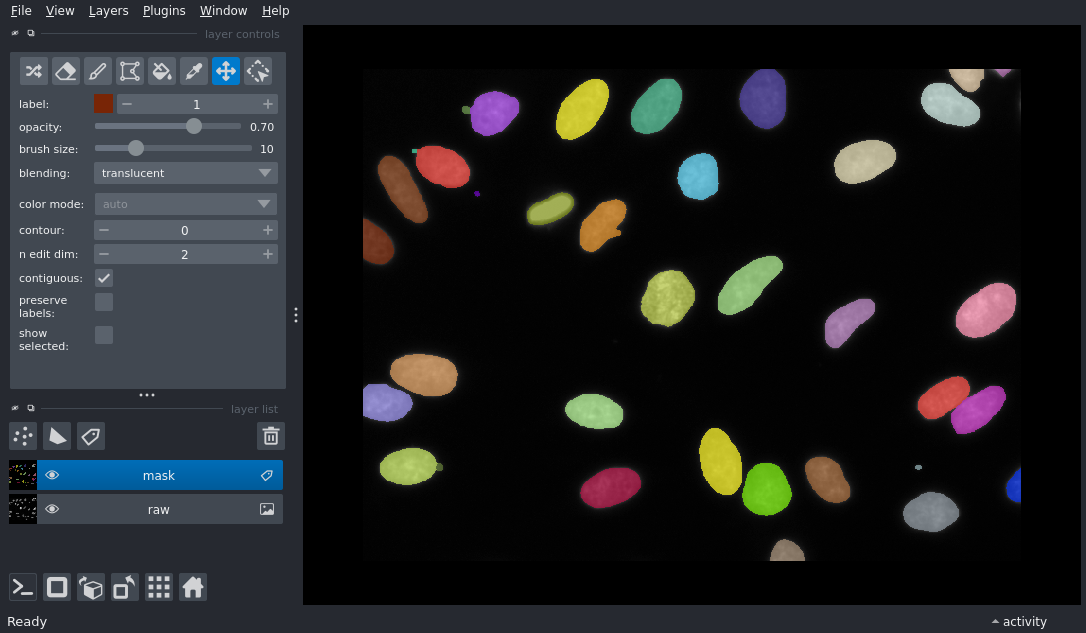

In [12]:
from napari.utils import nbscreenshot

nbscreenshot(v)

#### Hints
- What [layer type](https://napari.org/stable/howtos/layers/index.html) fits your data best?
- If your data has multiple channels, add each channel as a separate layer and experiment with blending modes/visibility
- What visualization will be the best for checking the prediction quality in the future? Does it make sense to transform the data before visualizing, for example, take a difference of ground truth and prediction? 